<a href="https://colab.research.google.com/github/PhilipPfeffer/haptic_vest/blob/main/mobilenet_retrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retrained MobileNet
MobileNet has been trained for many applications, including image segmentation, bounding box detection and ImageNet classification. In this notebook, we retrain the smallest version of MobileNet to classify whether an image in our dataset contains a 'person', a 'car' or 'neither.

# Acknowledgements
This was inspired by https://www.tensorflow.org/tutorials/images/transfer_learning (Accessed 29 Oct 2020).

# Code

## Imports
General Setup; GPU setup is under Training.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import zipfile
import shutil
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
import sklearn 
from sklearn import metrics
import tensorflow_addons as tfa


# Unzip Dataset

In [2]:
dataset_name = 'dataset_three'
zip_file_path = '/content/' + dataset_name + '.zip'
unzipped_dir = '/content'
dataset_X = '/content/' + dataset_name
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzipped_dir)

# Create Dataloader

In [3]:
BATCH_SIZE = 32
ORIG_IMG_SIZE = (96, 96)
ORIG_COLOR_MODE ='grayscale'
IMG_SIZE = (128,128)
COLOR_MODE = 'rgb'

train_dataset = image_dataset_from_directory(dataset_X +'/train/', label_mode='categorical', shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, color_mode=COLOR_MODE)
dev_dataset = image_dataset_from_directory(dataset_X +'/dev/', label_mode='categorical', shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, color_mode=COLOR_MODE)
test_dataset = image_dataset_from_directory(dataset_X +'/test/', label_mode='categorical', shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, color_mode=COLOR_MODE)

Found 65955 files belonging to 3 classes.
Found 9225 files belonging to 3 classes.
Found 4780 files belonging to 3 classes.


In [7]:
def show_example(train_dataset):
  for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = np.asarray(image[0]).squeeze()
    print(first_image.shape)
    # for i in range(9):
    #   ax = plt.subplot(3, 3, i + 1)
      # augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
      # plt.imshow(augmented_image[0] / 255)
    # print(image)
    plt.imshow(first_image / 255)
    plt.axis('off')
    
    break 

# Run with this line:
# show_example(train_dataset)

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
dev_dataset = dev_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Data Augmentation
Add data augmentation to all images

In [9]:
# data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
#   tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
# ])

# MobileNet Model

In [10]:
preprocess_input = tf.keras.applications.mobilenet.preprocess_input

In [11]:
# Loading model from https://www.tensorflow.org/lite/guide/hosted_models#image_classification

# Create the base model from the pre-trained model MobileNet
IMG_SHAPE = IMG_SIZE + (3,)

#Same syntax for MobileNetV2 and V1
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                               alpha=0.25, # just add this
                                               include_top=False,
                                               weights='imagenet')

2113536/2108140 [==============================] - 0s 0us/step


In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 4, 4, 256)


# GPU Setup

In [13]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: ignored

In [ ]:
base_model.trainable = False
base_model.summary()
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
prediction_layer = tf.keras.layers.Dense(3, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

Model: "mobilenet_0.25_128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 8)         216       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 8)         32        
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 8)         0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 8)         72        
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 8)  

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
def f1_score(num_classes):
  return tfa.metrics.F1Score(num_classes=num_classes, average="weighted")

In [ ]:
base_learning_rate = 0.0001
# Compile model with accuracy and weighted F1 Score
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), metrics=['accuracy',  f1_score(num_classes)])

# model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
#               loss=tf.keras.losses.CategoricalCrossentropy(),
#               metrics=['accuracy'])

In [ ]:
model.summary()
len(model.trainable_variables)

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv_2 (Tenso [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_2 (TensorFlo [(None, 128, 128, 3)]     0         
_________________________________________________________________
mobilenet_0.25_128 (Function (None, 4, 4, 256)         218544    
_________________________________________________________________
global_average_pooling2d_1 ( (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)              

2

# Training (Stage 1: Frozen)

In [ ]:
initial_epochs = 20

loss0, accuracy0, f1_score0 = model.evaluate(dev_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
print("initial f1_score: {:.2f}".format(f1_score0))

223/223 [==============================] - 5s 23ms/step - loss: 1.7575 - accuracy: 0.2345 - f1_score: 0.2440
initial loss: 1.76
initial accuracy: 0.23
initial f1_score: 0.24


In [ ]:
# Configure eary stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
with tf.device('/device:GPU:0'):
  history = model.fit(train_dataset,
                  epochs=initial_epochs,
                  validation_data=dev_dataset,
                  callbacks=[early_stopping])

Epoch 1/20
1703/1703 [==============================] - 46s 27ms/step - loss: 0.8347 - accuracy: 0.6132 - f1_score: 0.6137 - val_loss: 0.8579 - val_accuracy: 0.7118 - val_f1_score: 0.6821
Epoch 2/20
1703/1703 [==============================] - 46s 27ms/step - loss: 0.6482 - accuracy: 0.7035 - f1_score: 0.6977 - val_loss: 0.7959 - val_accuracy: 0.7395 - val_f1_score: 0.7085
Epoch 3/20
1703/1703 [==============================] - 44s 26ms/step - loss: 0.5968 - accuracy: 0.7269 - f1_score: 0.7208 - val_loss: 0.7561 - val_accuracy: 0.7467 - val_f1_score: 0.7148
Epoch 4/20
1703/1703 [==============================] - 44s 26ms/step - loss: 0.5772 - accuracy: 0.7365 - f1_score: 0.7303 - val_loss: 0.7259 - val_accuracy: 0.7506 - val_f1_score: 0.7183
Epoch 5/20
1703/1703 [==============================] - 43s 25ms/step - loss: 0.5654 - accuracy: 0.7436 - f1_score: 0.7373 - val_loss: 0.7108 - val_accuracy: 0.7543 - val_f1_score: 0.7225
Epoch 6/20
1703/1703 [==============================] - 42s 

In [ ]:
model.save('/content/three_model_stage1')

save_to_drive=False
if save_to_drive:
  model.save('/content/drive/My Drive/Haptic Vest/three_model_stage1')

# Learning Plot

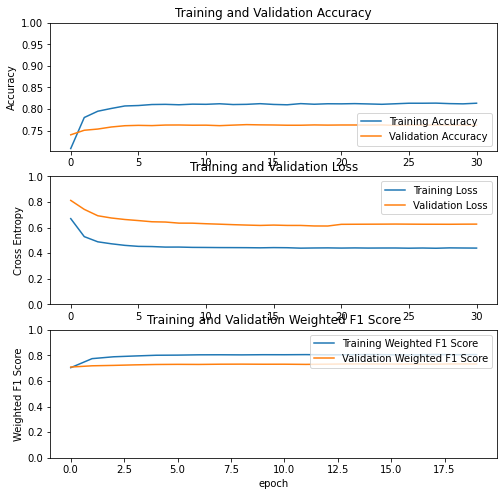

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


f1_score = history.history['f1_score']
val_f1_score = history.history['val_f1_score']

plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(3, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')

plt.subplot(3, 1, 3)
plt.plot(f1_score, label='Training Weighted F1 Score')
plt.plot(val_f1_score, label='Validation Weighted F1 Score')
plt.legend(loc='upper right')
plt.ylabel('Weighted F1 Score')
plt.ylim([0,1.0])
plt.title('Training and Validation Weighted F1 Score')
plt.xlabel('epoch')
plt.show()

From GOOGLE
Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

# Training (Stage 2: Unfrozen)

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  87


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy', f1_score(num_classes)])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 128, 128, 3)]     0         
_________________________________________________________________
mobilenet_0.25_128 (Function (None, 4, 4, 256)         218544    
_________________________________________________________________
global_average_pooling2d (Gl (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                

In [ ]:
len(model.trainable_variables)

2

### Continue training the model

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=dev_dataset, 
                         callbacks=[early_stopping])

Epoch 20/30
1703/1703 [==============================] - 47s 28ms/step - loss: 0.4397 - accuracy: 0.8120 - f1_score: 0.8065 - val_loss: 0.6253 - val_accuracy: 0.7628 - val_f1_score: 0.7323
Epoch 21/30
1703/1703 [==============================] - 51s 30ms/step - loss: 0.4409 - accuracy: 0.8125 - f1_score: 0.8071 - val_loss: 0.6259 - val_accuracy: 0.7628 - val_f1_score: 0.7322
Epoch 22/30
1703/1703 [==============================] - 51s 30ms/step - loss: 0.4398 - accuracy: 0.8118 - f1_score: 0.8063 - val_loss: 0.6263 - val_accuracy: 0.7627 - val_f1_score: 0.7321
Epoch 23/30
1703/1703 [==============================] - 51s 30ms/step - loss: 0.4402 - accuracy: 0.8109 - f1_score: 0.8055 - val_loss: 0.6267 - val_accuracy: 0.7630 - val_f1_score: 0.7325
Epoch 24/30
1703/1703 [==============================] - 50s 29ms/step - loss: 0.4403 - accuracy: 0.8122 - f1_score: 0.8070 - val_loss: 0.6274 - val_accuracy: 0.7620 - val_f1_score: 0.7315
Epoch 25/30
1703/1703 [==============================] 

In [ ]:
model.save('/content/three_model_stage2')

save_to_drive=False
if save_to_drive:
  model.save('/content/drive/My Drive/Haptic Vest/three_model_stage2')

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

f1_score = history.history['f1_score']
val_f1_score = history.history['val_f1_score']

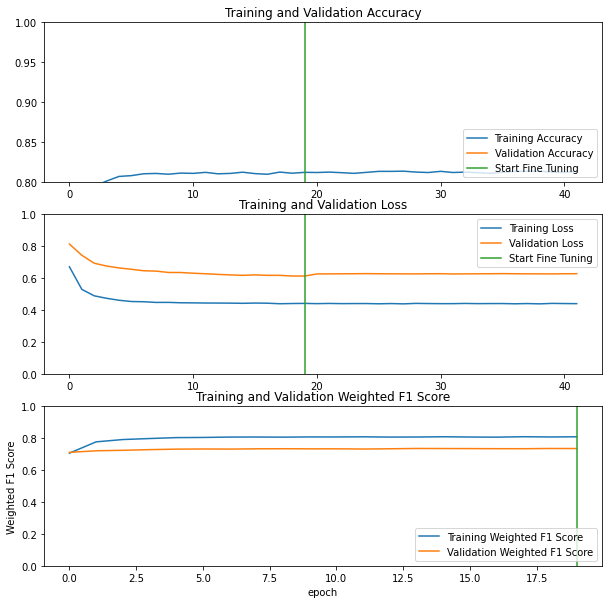

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(3, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(3, 1, 3)
plt.plot(f1_score, label='Training Weighted F1 Score')
plt.plot(val_f1_score, label='Validation Weighted F1 Score')
plt.legend(loc='lower right')
plt.ylabel('Weighted F1 Score')
plt.ylim([0,1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.title('Training and Validation Weighted F1 Score')
plt.xlabel('epoch')
plt.show()

# Load Model

In [ ]:
load_model_path='/content/three_model_stage1'
# load_model_path='/content/three_model_stage2'
loaded_model = keras.models.load_model(load_model_path, custom_objects={'F1Score': tfa.metrics.F1Score})

# Evaluation and prediction

In [ ]:
# loss, accuracy, f1_score = loaded_model.evaluate(test_dataset)
# print('Test accuracy :', accuracy)

Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [[0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


NameError: ignored

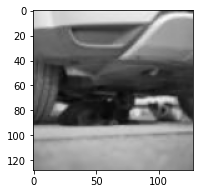

In [ ]:
# Define classes
classes = ['neither', 'person', None , 'car']

#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

# print('Predictions:\n', predictions.numpy())
# print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(classes[predictions[i]])
  plt.axis("off")

# Convert the model to tflite

In [ ]:
# Convert
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpwgyqidrd/assets


# Build for Raspberry Pi

#### Reference: https://www.tensorflow.org/lite/guide/build_rpi